In [7]:
import pandas as pd
import utilities.data_preprocessing as dp

# importing data into dataframes
movies_df = pd.read_csv("data/movies.csv")
tags_df = pd.read_csv("data/tags.csv")
links_df = pd.read_csv("data/links.csv")
ratings_df = pd.read_csv("data/ratings.csv")
movie_details_df = pd.read_csv("data/movie_details.csv")

### Fetch details of every movie **!!!DO NOT RUN IF FILE IS PRESENT!!!**

In [15]:
import utilities.data_preprocessing as dp
import importlib
importlib.reload(dp)

movie_list = movies_df['movieId'].tolist()

dp.process_movie_list(movie_list, "access_token.json", "data/movie_details.csv")

Movie details saved to data/movie_details.csv incrementally.


### *movies.csv* data file preprocessing

In [ ]:
# checking data types
movies_df["movieId"] = dp.check_data_type(movies_df["movieId"], int)
movies_df["title"] = dp.check_data_type(movies_df["title"], str)
movies_df["genres"] = dp.check_data_type(movies_df["genres"], str)

movies_df = movies_df.dropna()

87585

In [44]:
# making data more informative and convenient work with
movies_df["year"] = movies_df["title"].apply(lambda value: dp.extract_movie_year(value))
movies_df["title"] = movies_df["title"].apply(lambda value: dp.clean_movie_title(value))
movies_df["genres"] = movies_df["genres"].apply(lambda value: dp.extract_movie_genres(value))

movies_df.head()

,movieId,title,genres,year
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995.0
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995.0
2,3,Grumpier Old Men,"[Comedy, Romance]",1995.0
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995.0
4,5,Father of the Bride Part II,[Comedy],1995.0


### *tags.csv* data file preprocessing

In [ ]:
# checking data types
tags_df["userId"] = dp.check_data_type(tags_df["userId"], int)
tags_df["movieId"] = dp.check_data_type(tags_df["movieId"], int)
tags_df["tag"] = dp.check_data_type(tags_df["tag"], str)
tags_df["timestamp"] = dp.check_data_type(tags_df["timestamp"], int)

tags_df = tags_df.dropna()

2000055

In [46]:
# making data more informative and convenient work with
tags_df["tag"] = tags_df["tag"].apply(lambda value: value.lower())

tags_df.head()

,userId,movieId,tag,timestamp
0,22,26479,kevin kline,1583038886
1,22,79592,misogyny,1581476297
2,22,247150,acrophobia,1622483469
3,34,2174,music,1249808064
4,34,2174,weird,1249808102


### *links.csv* data file preprocessing

In [ ]:
# checking data types
links_df["movieId"] = dp.check_data_type(links_df["movieId"], int)
links_df["imdbId"] = dp.check_data_type(links_df["imdbId"], int)
links_df["tmdbId"] = dp.check_data_type(links_df["tmdbId"], float)

links_df = links_df.dropna()
links_df.head()

87461

### *ratings.csv* data file preprocessing

In [ ]:
# checking data types
ratings_df["userId"] = dp.check_data_type(ratings_df["userId"], int)
ratings_df["movieId"] = dp.check_data_type(ratings_df["movieId"], int)
ratings_df["rating"] = dp.check_data_type(ratings_df["rating"], float)
ratings_df["timestamp"] = dp.check_data_type(ratings_df["timestamp"], int)

ratings_df = ratings_df.dropna()

32000204

### Combine movies and their tags

In [50]:
movie_tags_dict = tags_df.groupby('movieId')["tag"].unique().apply(lambda group: group.tolist()).to_dict()
movies_df['tags'] = movies_df['movieId'].apply(lambda id: movie_tags_dict.get(id, []))

movies_df.head()

,movieId,title,genres,year,tags
0,1,Toy Story,"[Adventure, Animation, Children, Comedy, Fantasy]",1995.0,"[children, disney, animation, pixar, funny, tu..."
1,2,Jumanji,"[Adventure, Children, Fantasy]",1995.0,"[robin williams, fantasy, time travel, animals..."
2,3,Grumpier Old Men,"[Comedy, Romance]",1995.0,"[comedinha de velhinhos engraãƒâ§ada, comedinh..."
3,4,Waiting to Exhale,"[Comedy, Drama, Romance]",1995.0,"[characters, slurs, based on novel or book, ch..."
4,5,Father of the Bride Part II,[Comedy],1995.0,"[fantasy, pregnancy, remake, family, steve mar..."


### *movie_details.csv* file preprocessing

In [23]:
import utilities.data_preprocessing as dp
import pandas as pd
import importlib
import spacy
import nltk
from nltk.corpus import stopwords
importlib.reload(dp)

nlp = spacy.load("en_core_web_md")
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

movies_df = pd.merge(movies_df, movie_details_df, on="movieId", how="inner",suffixes=('_left', '_right'))

movies_df = movies_df.drop(columns=['title_right', 'genres_left'])
movies_df = movies_df.rename(columns={'title_left': 'title', 'genres_right': 'genres'})


movies_df['overview'] = movies_df['overview'].apply(
   lambda x: dp.preprocess_text(x, nlp, stop_words)
)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/naudotojas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Solution 1: Recommendations based on cosine similarity

### Combine all features into a single one

In [24]:
import utilities.data_preprocessing as dp
import pandas as pd
import importlib
importlib.reload(dp)

def combine_features(row):
   features = [
      str(row['title']), 
      str(row['release_date']),
      str(row['genres']), 
      str(row['production_companies']), 
      str(row['overview']), 
      " ".join(row['tags'])
   ]
   return " ".join(features)

movies_df['combined_features'] = movies_df.apply(combine_features, axis=1)
movies_df = movies_df.dropna(subset=['combined_features'])

print(movies_df[['movieId', 'title', 'combined_features']].head())

movies_df.to_csv("data/movies_with_combined_features.csv", index=False)

   movieId                        title  \
0        2                      Jumanji   
1        3             Grumpier Old Men   
2        5  Father of the Bride Part II   
3        6                         Heat   
4        8                 Tom and Huck   

                                   combined_features  
0  Jumanji 1988-10-21 Comedy, Drama, Romance, Cri...  
1  Grumpier Old Men 1986-10-17 Comedy, Drama, Rom...  
2  Father of the Bride Part II 1995-12-09 Comedy ...  
3  Heat 1993-10-15 Action, Crime, Thriller Largo ...  
4  Tom and Huck 2006-01-01 Documentary inLoops ti...  


## Vectorization of the combined features

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=6666)

movies_combined_df = pd.read_csv("data/movies_with_combined_features.csv")

vectorized_data = tfidf.fit_transform(movies_combined_df['combined_features'].values)
vectorized_dataframe = pd.DataFrame(vectorized_data.toarray(), index=movies_combined_df['combined_features'].index.tolist())
vectorized_dataframe.shape

(50404, 6666)

## Reducing the dimension of the vectorized data

In [27]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=3333)

reduced_data = svd.fit_transform(vectorized_dataframe)
reduced_data.shape

(50404, 3333)

# Cosine similarity recommendation

In [29]:
from sklearn.metrics.pairwise import cosine_similarity
similarity = cosine_similarity(reduced_data)

In [35]:
def recommendation(movie_title):
   id_of_movie = movies_combined_df[movies_df['title'].str.contains(movie_title, case=False, na=False)].index[0]
   
   print("Input movie:")
   print(f"{'ID':<6} | {'Title':<50}")
   print(f"{'-'*6} | {'-'*50}")
   print(f"{movies_combined_df.iloc[id_of_movie].movieId:<6} | {movies_combined_df.iloc[id_of_movie].title:<50}")
   
   distances = similarity[id_of_movie]
   movie_list = sorted(list(enumerate(distances)), reverse=True, key=lambda x: x[1])[1:10]
   
   print("\nRecommended Movies:")
   print(f"{'ID':<6} | {'Title':<50}")
   print(f"{'-'*6} | {'-'*50}")
   for i in movie_list:
      print(f"{movies_combined_df.iloc[i[0]].movieId:<6} | {movies_combined_df.iloc[i[0]].title:<50}")

recommendation("Star trek")


Input movie:
ID     | Title                                             
------ | --------------------------------------------------
329    | Star Trek: Generations                            

Recommended Movies:
ID     | Title                                             
------ | --------------------------------------------------
1375   | Star Trek III: The Search for Spock               
1374   | Star Trek II: The Wrath of Khan                   
1373   | Star Trek V: The Final Frontier                   
1371   | Star Trek: The Motion Picture                     
1372   | Star Trek VI: The Undiscovered Country            
2393   | Star Trek: Insurrection                           
1376   | Star Trek IV: The Voyage Home                     
166528 | Rogue One: A Star Wars Story                      
122912 | Avengers: Infinity War - Part I                   


# Solution 2: Recommendations based on user's liked movies and the cosine similarity of tags

### Data loading and pre-processing for tags

In [12]:
import numpy as np
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import spacy
import nltk
from nltk.corpus import stopwords

nlp = spacy.load("en_core_web_md")
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Drop rows with missing data
ratings_df.dropna(subset=['userId', 'movieId', 'rating'], inplace=True)
tags_df.dropna(subset=['movieId', 'tag'], inplace=True)
movies_df.dropna(subset=['movieId', 'title'], inplace=True)

# Combine all tags for each movie
tags_combined = tags_df.groupby('movieId')['tag'].apply(lambda tags: " ".join(tags)).reset_index()

# Preprocess combined tags
def preprocess_tags_batch(text):
    doc = nlp(text.lower())
    cleaned_tokens = [
        token.lemma_ for token in doc if token.is_alpha and token.lemma_ not in stop_words
    ]
    return " ".join(cleaned_tokens)

tags_combined['tag'] = tags_combined['tag'].apply(preprocess_tags_batch)

# Merge preprocessed tags with movies
movies_with_tags = pd.merge(movies_df, tags_combined, on='movieId', how='left')
movies_with_tags['tag'] = movies_with_tags['tag'].fillna("")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gabri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Get user liked movies

In [13]:
def get_user_liked_movies(user_id, threshold=4.0):
    liked_movies = ratings_df[(ratings_df['userId'] == user_id) & (ratings_df['rating'] >= threshold)]['movieId']
    return movies_with_tags[movies_with_tags['movieId'].isin(liked_movies)]

### Build user profile

In [14]:
def build_user_profile(liked_movies, top_n_tags=5, max_repeats=5):
    # Combine all tags from liked movies
    tags_combined = " ".join(liked_movies['tag'])
    
    # Count and normalize tag occurrences
    tag_counts = Counter(tags_combined.split())
    total_tags = sum(tag_counts.values())
    normalized_tags = {tag: count / total_tags for tag, count in tag_counts.items()}
    
    # Sort tags by normalized frequency
    most_common_tags = sorted(normalized_tags.items(), key=lambda x: x[1], reverse=True)
    
    # Limit the profile to top_n_tags
    user_profile = " ".join([tag for tag, _ in most_common_tags[:top_n_tags]])
    return user_profile


### Recommendation based on tags of liked movies

In [15]:
def recommend_movies_by_user_tags(user_id, top_n=5, top_n_tags=10):
    liked_movies = get_user_liked_movies(user_id)

    if liked_movies.empty:
        print(f"User {user_id} has no liked movies rated above 4.0.")
        return

    print(f"Movies Liked by User {user_id}:")
    display(liked_movies[['title', 'tag']].head(5))

    user_profile = build_user_profile(liked_movies, top_n_tags=top_n_tags)
    print(f"\nUser {user_id}'s Tag-Based Preference Profile:\n{user_profile}")

    # TF-IDF vectorization and similarity computation
    tfidf = TfidfVectorizer(max_features=5000)
    tfidf_input = pd.concat([movies_with_tags['tag'], pd.Series(user_profile)], ignore_index=True)
    tfidf_matrix = tfidf.fit_transform(tfidf_input)

    user_profile_vector = tfidf_matrix[-1]  
    movie_vectors = tfidf_matrix[:-1]       
    similarity_scores = cosine_similarity(user_profile_vector, movie_vectors)[0]

    # Add similarity scores and filter recommendations
    movies_with_tags['similarity'] = similarity_scores
    recommended_movies = movies_with_tags[~movies_with_tags['movieId'].isin(liked_movies['movieId'])]
    recommended_movies = recommended_movies.sort_values(by='similarity', ascending=False).head(top_n)

    # Display recommendations
    print(f"\nRecommended Movies for User {user_id}:")
    display(recommended_movies[['title', 'genres', 'similarity']].style.format({'similarity': "{:.2f}"}).background_gradient(cmap='YlGn'))


### Test the recommendations

In [25]:
user_id = 8865
recommend_movies_by_user_tags(user_id=user_id, top_n=5, top_n_tags=20)

Movies Liked by User 8865:


,title,tag
188,Safe,ambiguous cinematography criterion environment...
423,"Bronx Tale, A",eric dvds al pacino mafia robert de niro mafia...
903,2001: A Space Odyssey,atmospheric space stanley kubrick ambiguous at...
1052,"Fish Called Wanda, A",tumey dvds dark comedy quirky humorous dark hu...
1070,E.T. the Extra-Terrestrial,aliens child comedy emotional family fantasy i...



User 8865's Tag-Based Preference Profile:
space oscar good story comedy classic atmospheric psychology sci fi true alien base end mental dark illness surreal nudity cult

Recommended Movies for User 8865:


,title,genres,similarity
257,Star Wars: Episode IV - A New Hope,"['Action', 'Adventure', 'Sci-Fi']",0.46
2977,"Adventures of Buckaroo Banzai Across the 8th Dimension, The","['Adventure', 'Comedy', 'Sci-Fi']",0.46
19072,Lipton Cockton in the Shadows of Sodoma,"['Drama', 'Mystery', 'Sci-Fi']",0.45
15903,Frankie and Alice,['Drama'],0.43
56167,The Last Scout,['Sci-Fi'],0.42


### Visualisation ✨

In [82]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import matplotlib.pyplot as plt
from collections import Counter

In [83]:
tags_flattened = [tag for row in movies_df["tags"] for tag in row]
tags_ctr = Counter(tags_flattened)

genres_flattened = [genre for row in movies_df["genres"] for genre in row]
genres_ctr = Counter(genres_flattened)

release_years = movies_df["year"]
years_ctr = Counter(release_years)

ratings = ratings_df['rating']

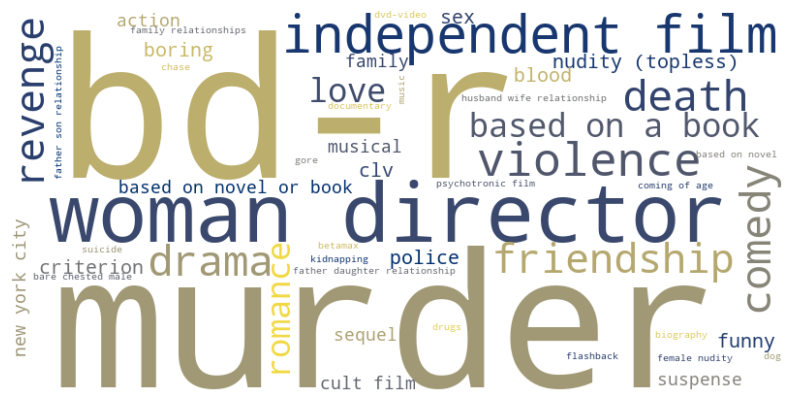

In [84]:
wc = WordCloud(
    background_color = "white",
    colormap = "cividis",
    max_words = 50,
    stopwords = STOPWORDS,
    max_font_size = 100,
    scale = 2
)

wc.generate_from_frequencies(tags_ctr)

plt.figure(figsize = (10, 10))
plt.imshow(wc, interpolation = "bilinear")
plt.axis("off")

plt.show()

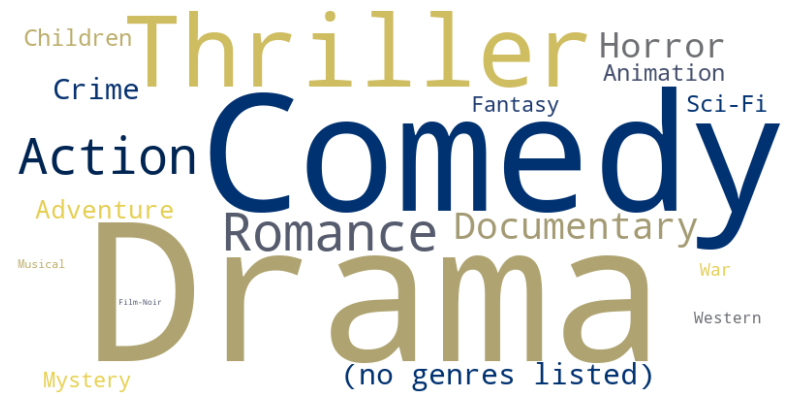

In [86]:
wc = WordCloud(
    background_color = "white",
    colormap = "cividis",
    max_words = 50,
    stopwords = STOPWORDS,
    max_font_size = 100,
    scale = 2
)

wc.generate_from_frequencies(genres_ctr)

plt.figure(figsize = (10, 10))
plt.imshow(wc, interpolation = "bilinear")
plt.axis("off")

plt.show()

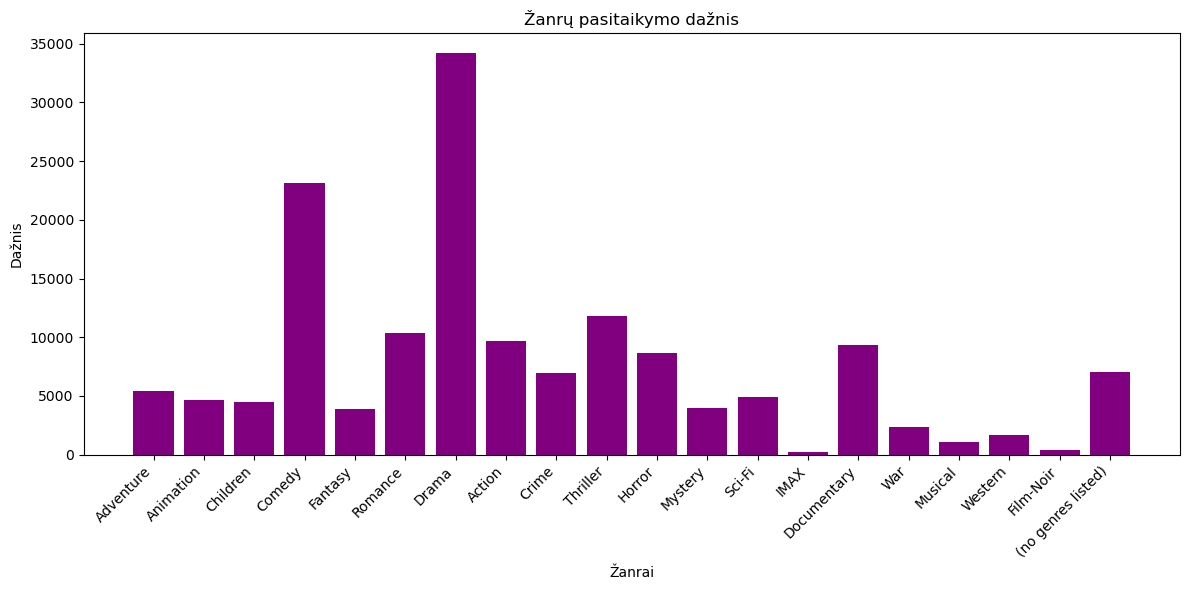

In [87]:
plt.figure(figsize = (12, 6))

plt.bar(genres_ctr.keys(), genres_ctr.values(), color='purple')

plt.title("Žanrų pasitaikymo dažnis")
plt.xlabel("Žanrai")
plt.ylabel("Dažnis")
plt.xticks(rotation = 45, ha = 'right')

plt.tight_layout()

plt.show()

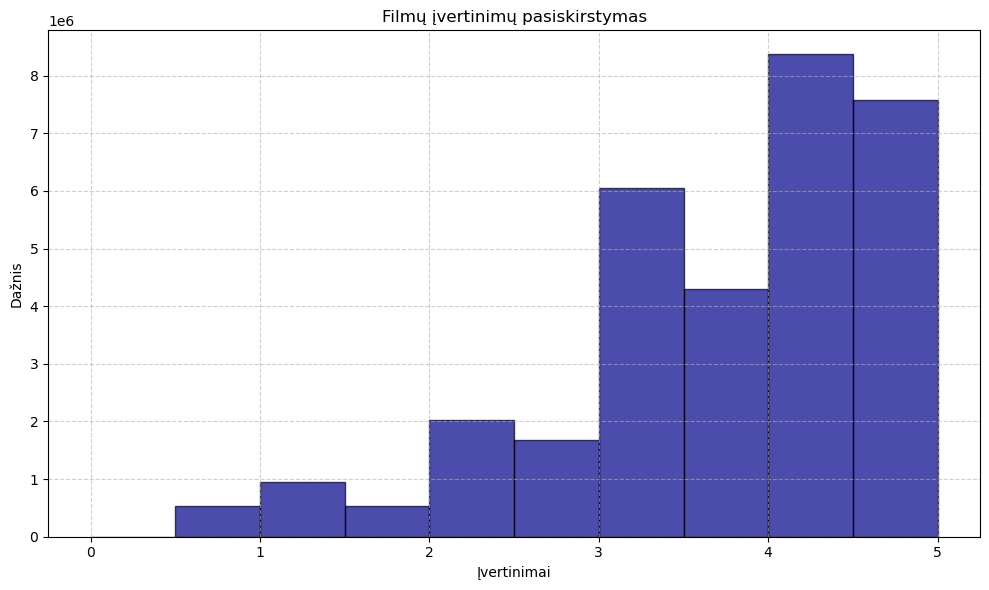

In [88]:
plt.figure(figsize = (10, 6))

bins = np.arange(0, 5.5, 0.5)
plt.hist(ratings, bins = bins, color = 'darkblue', edgecolor = 'black', alpha = 0.7)

plt.title("Filmų įvertinimų pasiskirstymas")
plt.xlabel("Įvertinimai")
plt.ylabel("Dažnis")
plt.grid(True, linestyle = '--', alpha = 0.6)

plt.tight_layout()

plt.show()

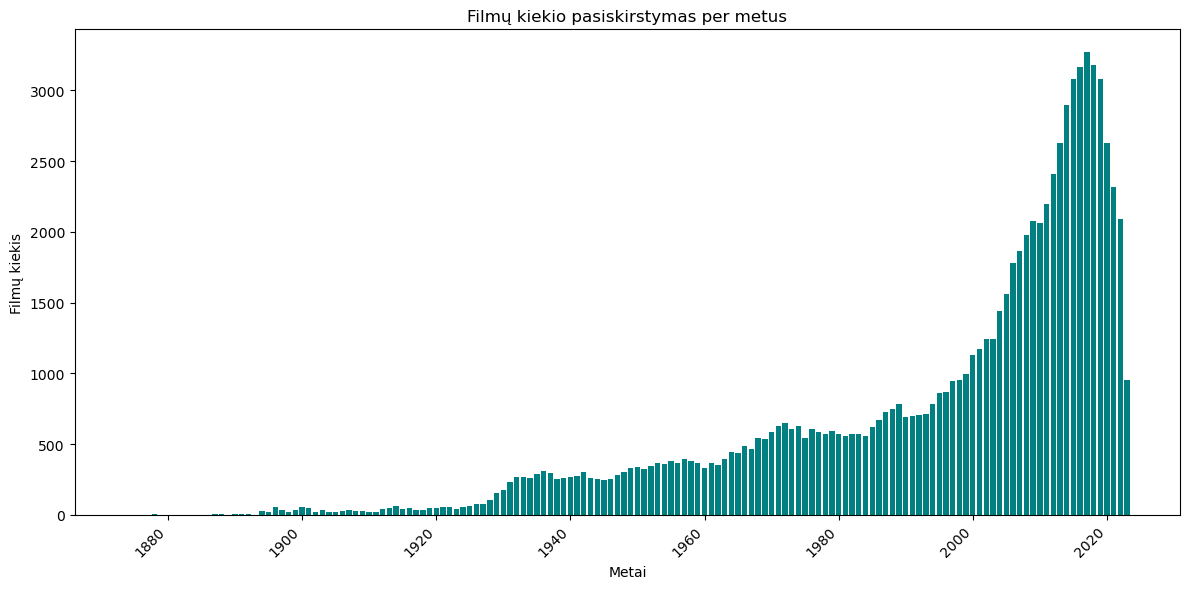

In [89]:
plt.figure(figsize = (12, 6))

plt.bar(years_ctr.keys(), years_ctr.values(), color='teal')

plt.title("Filmų kiekio pasiskirstymas per metus")
plt.xlabel("Metai")
plt.ylabel("Filmų kiekis")
plt.xticks(rotation = 45, ha = 'right')

plt.tight_layout()

plt.show()